# Classification using neural networks
- Neural networks; Tensorflow
- 2D synthetic gaussian mixture data for binary classification

In [1]:
# -*- coding: utf-8 -*-

import tensorflow as tf
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import norm
from IPython.display import Image, display, Math, Latex


# Params
n_inpoints = 100

C:\Users\Karma\Anaconda3\envs\tflo\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


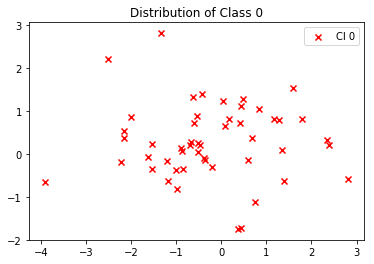

In [2]:
def generateClass0():
    theta0 = 0
    lmb01 = 2
    lmb02 = 1
    m0 = (0,  0)
    # computing u * u.T and later multiplying with lambda
    cov01 = [[(cos(theta0))**2,    cos(theta0)*sin(theta0)],
             [(sin(theta0))*cos(theta0), (sin(theta0))**2]]
    cov02 = [[(sin(theta0))**2,    -(cos(theta0)*sin(theta0))],
             [-(cos(theta0)*sin(theta0)), (cos(theta0))**2]]
    cov0 = lmb01*np.matrix(cov01) + lmb02*np.matrix(cov02)
    cov0_det = np.linalg.det(cov0)
    x0, y0 = np.random.multivariate_normal(m0, cov0, int(n_inpoints/2)).T
    return x0,y0

x0, y0 = generateClass0()
plt.scatter(x0, y0, color = 'r',marker='x', label = 'Cl 0')
plt.legend()
plt.title('Distribution of Class 0')
plt.show()

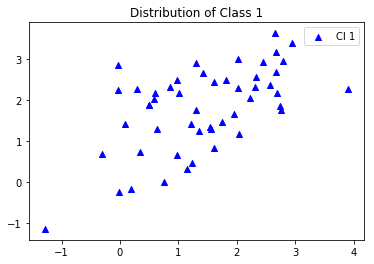

In [3]:
def generateClass1():
    # Mixture A
    theta1a = -3*pi/4
    lmb1a1 = 2
    lmb1a2 = 1/4
    m1a = (-2, 1)
    cov1a = [[(cos(theta1a))**2,    cos(theta1a)*sin(theta1a)],
             [(sin(theta1a))*cos(theta1a), (sin(theta1a))**2]]
    cov2a = [[(sin(theta1a))**2,    -(cos(theta1a)*sin(theta1a))],
             [-(cos(theta1a)*sin(theta1a)), (cos(theta1a))**2]]
    cov1a = lmb1a1*np.matrix(cov1a) + lmb1a2*np.matrix(cov2a)
    cov1a_det = np.linalg.det(cov1a)
    x1a, y1a = np.random.multivariate_normal(m1a, cov1a, int(n_inpoints/2)).T
    #print('Shape: ',x1a.shape,', ',y1a.shape,', ',cov1a)

    # Mixture B
    theta1b = pi/4
    lmb1b1 = 3
    lmb1b2 = 1
    m1b = (3, 2)
    cov1b = [[(cos(theta1b))**2,    cos(theta1b)*sin(theta1b)],
             [(sin(theta1b))*cos(theta1b), (sin(theta1b))**2]]
    cov2b = [[(sin(theta1b))**2,    -(cos(theta1b)*sin(theta1b))],
             [-(cos(theta1b)*sin(theta1b)), (cos(theta1b))**2]]
    cov1b = lmb1b1*np.matrix(cov1b) + lmb1b2*np.matrix(cov2b)
    cov1b_det = np.linalg.det(cov1b)
    x1b, y1b = np.random.multivariate_normal(m1b, cov1b, int(n_inpoints/2)).T
    #print('Shape: ',x1b.shape,', ',y1b.shape,', ',cov1b)

    # Class 1 (A * 0.33 +B * 0.66)
    y1 = np.array(y1a)* (1 / 3)+np.array(y1b)* (2 / 3)
    x1 = np.array(x1a)* (1 / 3)+np.array(x1b)* (2 / 3)
    return x1,y1

x1, y1 = generateClass1()
plt.scatter(x1, y1, color = 'b',marker='^', label = 'Cl 1')
plt.title('Distribution of Class 1')
plt.legend()
plt.show()

Shape; X: (100,) , Y: (100,)


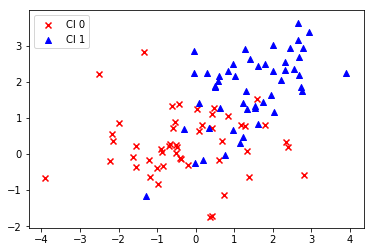

In [4]:
x = np.concatenate((x0, x1))
y = np.concatenate((y0, y1))
print('Shape; X:',x.shape,', Y:',y.shape)
plt.scatter(x0, y0, color = 'r',marker='x', label = 'Cl 0')
plt.scatter(x1, y1, color = 'b',marker='^', label = 'Cl 1')
plt.legend()
plt.show()

c0 = np.vstack((x0, y0)).T
c1 = np.vstack((x1, y1)).T
# ----------------------------------------
# Set up the [xi, yi] training data vector
# ----------------------------------------
X = np.concatenate((c0,c1), axis = 0)
Y = np.array([0]*int(n_inpoints/2) + [1]*int(n_inpoints/2)).reshape(n_inpoints,1)

### Training, test and validation sets (70:20:10)

In [5]:

# Divide the data into Train Valid, Test
tot_count = n_inpoints
trn_count = 70
val_count = 20
tst_count = 10

# Shuffle X & Y values
sfl_idx = np.arange(0,tot_count)
np.random.shuffle(sfl_idx)

Xc0 = X[:,0]
Xc1 = X[:,1]
Xc0 = Xc0.reshape(tot_count,1)
Xc1 = Xc1.reshape(tot_count,1)
print(Xc1.shape)

train_X0 = Xc0[sfl_idx[np.arange(0,trn_count)]]
train_X1 = Xc1[sfl_idx[np.arange(0,trn_count)]]
train_Y = Y[sfl_idx[np.arange(0,trn_count)]]
n_samples = train_X1.shape[0]

#valid_X = Xc[sfl_idx[np.arange(trn_count,trn_count+val_count)]]
#valid_Y = Y[sfl_idx[np.arange(trn_count,trn_count+val_count)]]

#tests_X = Xc[sfl_idx[np.arange(trn_count+val_count, tot_count)]]
#tests_Y = Y[sfl_idx[np.arange(trn_count+val_count, tot_count)]]

batchIndex = 0
def getNextTrainBatch(size):
    global batchIndex
    if((batchIndex + size) >= trn_count):
        size = trn_count-1
    
    #trn_sfl_idx = np.arange(0,trn_count)
    #np.random.shuffle(trn_sfl_idx)
    trn_X0_r1 =  train_X0[np.arange(batchIndex, batchIndex  + size)]
    trn_X1_r1 =  train_X1[np.arange(batchIndex, batchIndex  + size)]
    trn_Y_r1  =   train_Y[np.arange(batchIndex, batchIndex  + size)]
    print(trn_X0_r1.shape)
    trn_X = np.vstack((trn_X0_r1.T, trn_X1_r1.T))
    print((trn_X.T).shape)
    batchIndex = batchIndex  + size
    return trn_X.T, trn_Y_r1

#print(getNextTrainBatch(5))

#print('Train: ',train_X.shape, train_Y.T)
#print('Valid: ',valid_X.shape, valid_Y.T)
#print('Tests: ',tests_X.shape, tests_Y.T)

(100, 1)


Epoch: 0050 cost= 0.080227666 W= [[0.23670696]] b= [[0.13282688]]
Epoch: 0100 cost= 0.073678620 W= [[0.27767047]] b= [[0.16551374]]
Epoch: 0150 cost= 0.073295251 W= [[0.2823912]] b= [[0.17777796]]
Epoch: 0200 cost= 0.073185302 W= [[0.28086057]] b= [[0.18497951]]
Epoch: 0250 cost= 0.073119424 W= [[0.2786278]] b= [[0.19025867]]
Epoch: 0300 cost= 0.073077202 W= [[0.27664664]] b= [[0.19439985]]
Epoch: 0350 cost= 0.073050022 W= [[0.27502128]] b= [[0.19770433]]
Epoch: 0400 cost= 0.073032536 W= [[0.2737106]] b= [[0.2003521]]
Epoch: 0450 cost= 0.073021285 W= [[0.27265775]] b= [[0.20247567]]
Epoch: 0500 cost= 0.073014036 W= [[0.27181283]] b= [[0.20417924]]
Optimization Finished!
Training cost= 0.073014036 W= [[0.27181283]] b= [[0.20417924]] 



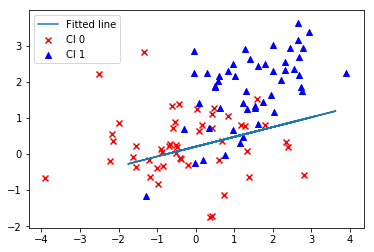

In [6]:
def linearRegression():
    # Parameters
    learning_rate = 0.01
    training_epochs = 500
    display_step = 50
    rng = np.random

    # tf Graph Input
    Xtf = tf.placeholder(tf.float32, [None, 1])
    Ytf = tf.placeholder(tf.float32, [None, 1])

    # Set model weights
    # figure tf.rand
    # tf.keras.initializer
    Wtf = tf.Variable(np.zeros([1,1]), dtype=tf.float32, name="weight")
    btf = tf.Variable(np.zeros([1,1]), dtype=tf.float32, name="bias")

    # Construct a linear model
    predtf = tf.add(tf.matmul(Xtf, Wtf), btf)

    # Mean squared error
    costtf = tf.reduce_sum(tf.pow(predtf-Ytf, 2))/(2*n_samples)
    # Gradient descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(costtf)

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:
        sess.run(init)

        # Fit all training data
        for epoch in range(training_epochs):
            sess.run(optimizer, feed_dict={Xtf: train_X1, Ytf: train_Y})
            #Display logs per epoch step
            if (epoch+1) % display_step == 0:
                c = sess.run(costtf, feed_dict={Xtf: train_X1, Ytf:train_Y})
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                    "W=", sess.run(Wtf), "b=", sess.run(btf))
        print("Optimization Finished!")
        training_cost = sess.run(costtf, feed_dict={Xtf: train_X1, Ytf: train_Y})
        print("Training cost=", training_cost, "W=", sess.run(Wtf), "b=", sess.run(btf), '\n')

        #Graphic display plt.plot(train_X, train_Y, 'ro', label='Original data')
        plt.scatter(x0, y0, color = 'r',marker='x', label = 'Cl 0')
        plt.scatter(x1, y1, color = 'b',marker='^', label = 'Cl 1')
        plt.plot(train_X1, sess.run(Wtf) * train_X1 + sess.run(btf), label='Fitted line')
        plt.legend()
        plt.show()

# Run Linear Regression
linearRegression()

### Neural Network implementation
- 1.(a) One hidden layer

In [7]:
# Parameters
learning_rate = 0.00001
num_steps = 12
batch_size = 5
display_step = 1

# Network Parameters
n_hidden_1 = 10 # 1st layer number of neurons
num_input = 2  # data input (img shape: 28*28)
num_classes = 1 # total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias (initializing using random nromal)
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Create model
def neural_net(x):
    # Hidden fully connected layer 
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
#correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
correct_pred = tf.cast(tf.greater(tf.sigmoid(logits), 0.5), tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(correct_pred, y), tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

##keep i mind boolena to float32 tensor output

In [8]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = getNextTrainBatch(batch_size)
        # Run optimization op (backprop)
       # print(batch_x)
       # print(batch_y)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: tests_X,
                                      Y: tests_Y}))

(5, 1)
(5, 2)
Step 1, Minibatch Loss= 0.9081, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 2, Minibatch Loss= 3.0768, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 3, Minibatch Loss= 1.4306, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 4, Minibatch Loss= 3.6475, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 5, Minibatch Loss= 1.2367, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 6, Minibatch Loss= 4.5327, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 7, Minibatch Loss= 3.4580, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 8, Minibatch Loss= 2.3988, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 9, Minibatch Loss= 2.6105, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 10, Minibatch Loss= 3.1071, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 11, Minibatch Loss= 3.4842, Training Accuracy= 0.000
(5, 1)
(5, 2)
Step 12, Minibatch Loss= 3.3983, Training Accuracy= 0.000
Optimization Finished!


NameError: name 'tests_X' is not defined